In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import os
import pickle
%matplotlib inline

In [48]:
df = pd.read_csv(r"E:\Air-Quality-Index-Prediction\data\aqi_data.csv")
df.head()

,Unnamed: 0,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI
0,0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241
1,1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458
2,2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518
3,3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892
4,4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964


In [49]:
df.shape

(18776, 10)

In [50]:
df.isna().sum()

Unnamed: 0    0
date          0
co            0
no2           0
o3            0
so2           0
pm2_5         0
pm10          0
nh3           0
AQI           0
dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  18776 non-null  int64  
 1   date        18776 non-null  object 
 2   co          18776 non-null  float64
 3   no2         18776 non-null  float64
 4   o3          18776 non-null  float64
 5   so2         18776 non-null  float64
 6   pm2_5       18776 non-null  float64
 7   pm10        18776 non-null  float64
 8   nh3         18776 non-null  float64
 9   AQI         18776 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.4+ MB


In [52]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI
0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241
1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458
2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518
3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892
4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964


In [53]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Autumn'
    
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.month.apply(get_season)

In [54]:
df.head()

,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI,season
0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241,Autumn
1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458,Autumn
2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518,Autumn
3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892,Autumn
4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964,Autumn


In [55]:
df['hour'] = df['date'].dt.hour
df.head()

,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI,season,hour
0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241,Autumn,1
1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458,Autumn,2
2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518,Autumn,3
3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892,Autumn,4
4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964,Autumn,5


In [56]:
df['lag_AQI'] = df['AQI'].shift(1)
df['lag_pm2_5'] = df['pm2_5'].shift(1)

In [57]:
df.head()

,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI,season,hour,lag_AQI,lag_pm2_5
0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241,Autumn,1,NaN,NaN
1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458,Autumn,2,446.170241,364.61
2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518,Autumn,3,468.574458,420.96
3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892,Autumn,4,485.559518,463.68
4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964,Autumn,5,482.032892,454.81


In [58]:
df['is_weekend'] = df['date'].dt.dayofweek>=5


In [59]:
df.head()

,date,co,no2,o3,so2,pm2_5,pm10,nh3,AQI,season,hour,lag_AQI,lag_pm2_5,is_weekend
0,2020-11-25 01:00:00,2.61688,70.60,13.59,38.62,364.61,411.73,28.63,446.170241,Autumn,1,NaN,NaN,False
1,2020-11-25 02:00:00,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458,Autumn,2,446.170241,364.61,False
2,2020-11-25 03:00:00,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518,Autumn,3,468.574458,420.96,False
3,2020-11-25 04:00:00,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892,Autumn,4,485.559518,463.68,False
4,2020-11-25 05:00:00,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964,Autumn,5,482.032892,454.81,False


In [60]:
df.isna().sum()

date          0
co            0
no2           0
o3            0
so2           0
pm2_5         0
pm10          0
nh3           0
AQI           0
season        0
hour          0
lag_AQI       1
lag_pm2_5     1
is_weekend    0
dtype: int64

In [61]:
df.shape

(18776, 14)

In [62]:
df.dropna(inplace=True)

In [63]:
df.shape

(18775, 14)

In [64]:
df.drop(['date'], axis=1, inplace=True)
df.head()

,co,no2,o3,so2,pm2_5,pm10,nh3,AQI,season,hour,lag_AQI,lag_pm2_5,is_weekend
1,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,468.574458,Autumn,2,446.170241,364.61,False
2,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,485.559518,Autumn,3,468.574458,420.96,False
3,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,482.032892,Autumn,4,485.559518,463.68,False
4,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,479.380964,Autumn,5,482.032892,454.81,False
5,3.89862,117.90,40.05,101.09,437.25,511.79,42.05,475.051205,Autumn,6,479.380964,448.14,False


<!-- # Univariate Analysis -->

In [65]:
numerical_columns = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'AQI']
categorical_columns = ['season', 'is_weekend']

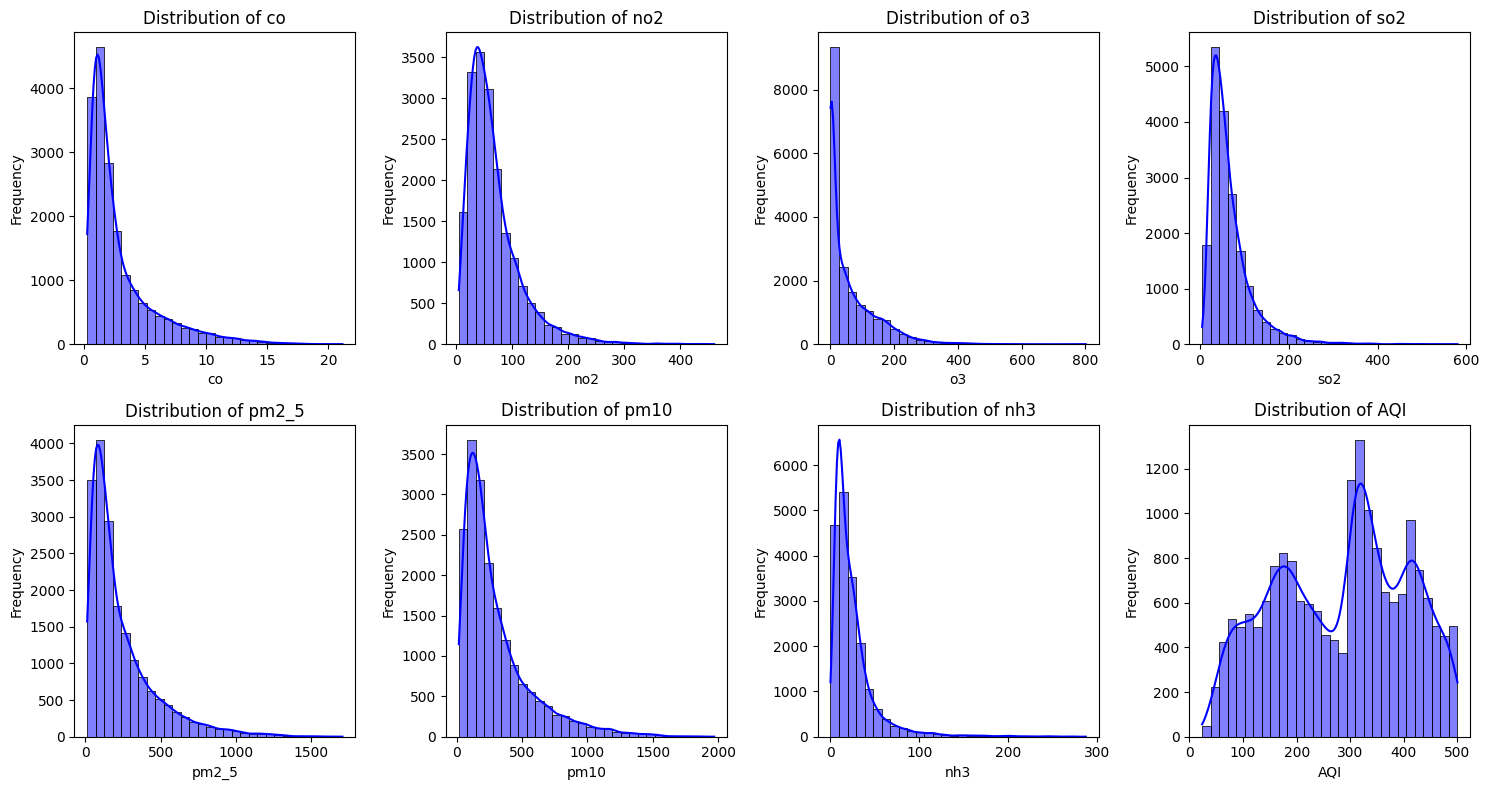

In [66]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


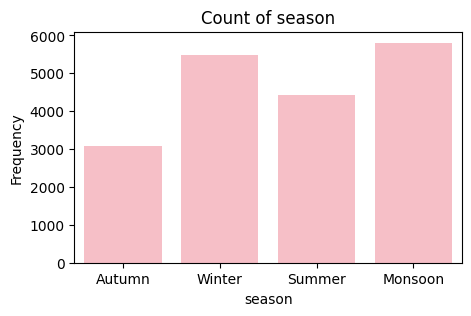

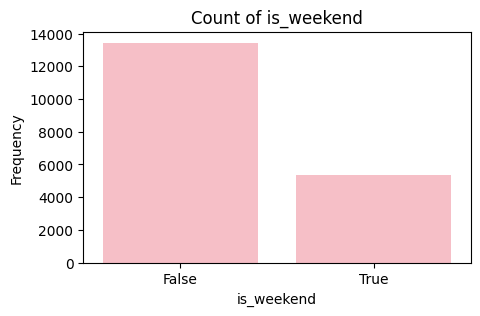

In [67]:
# Bar plots for categorical features
categorical_columns = ['season', 'is_weekend']
for col in categorical_columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=col, data=df, color='lightpink')
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


<!-- # Bivariate Analysis -->

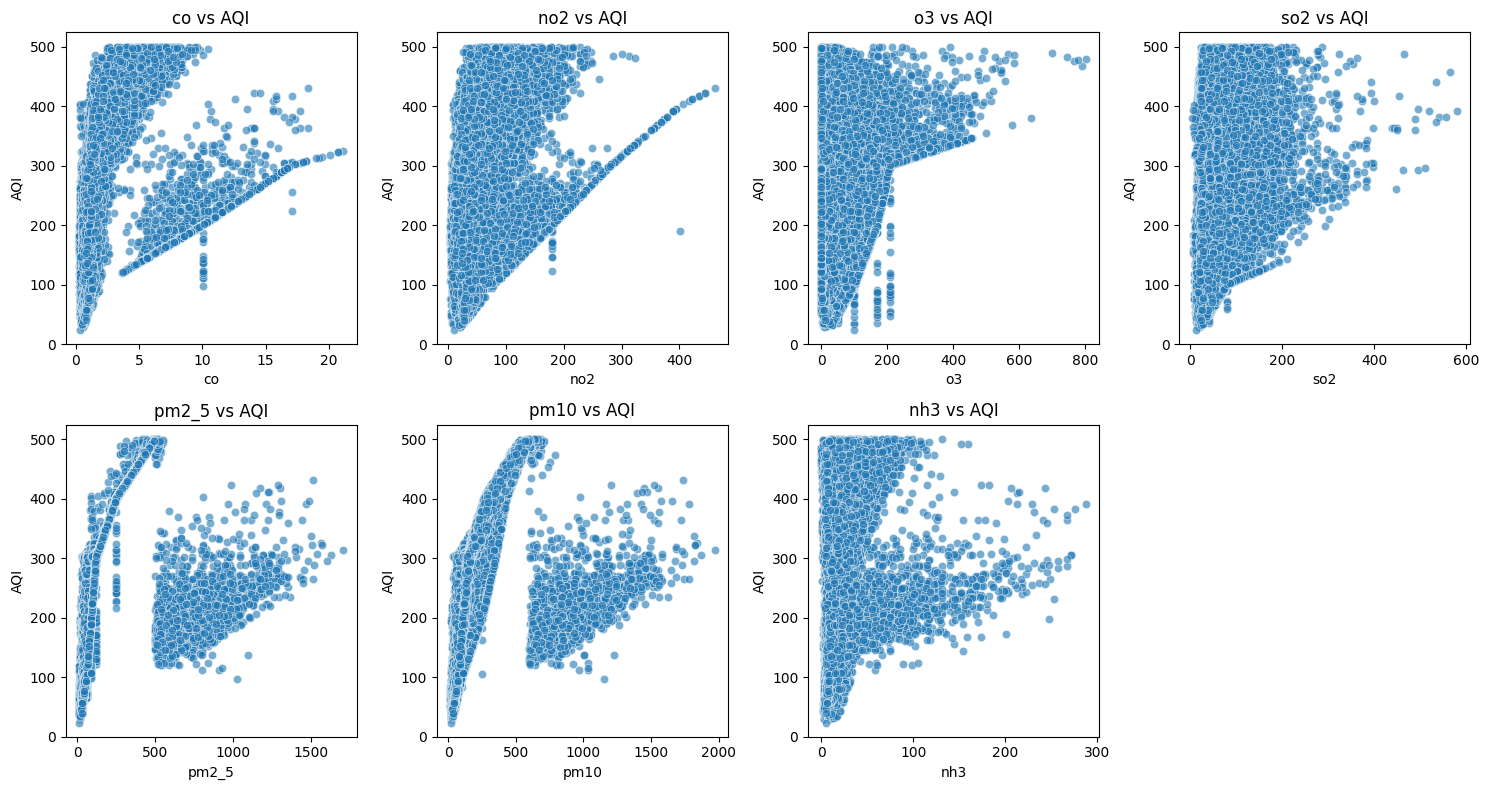

In [68]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns[:-1], start=1):
    plt.subplot(2, 4, i)
    sns.scatterplot(x=df[col], y=df['AQI'], alpha=0.6)
    plt.title(f'{col} vs AQI')
    plt.xlabel(col)
    plt.ylabel('AQI')

plt.tight_layout()
plt.show()


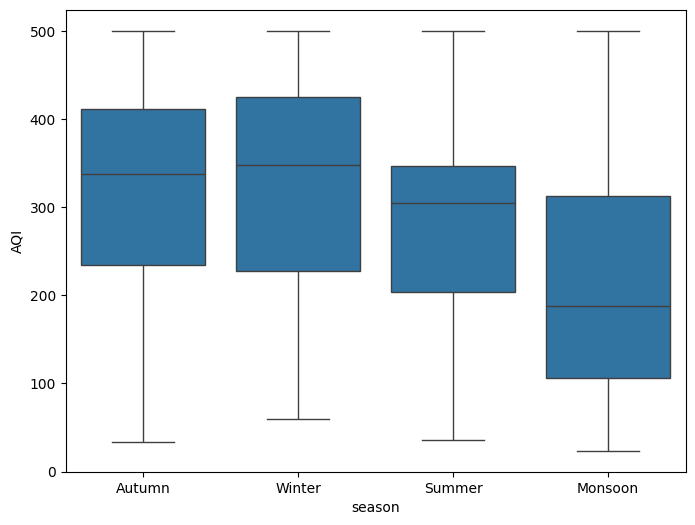

In [69]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='season', y='AQI', data=df)
plt.show()

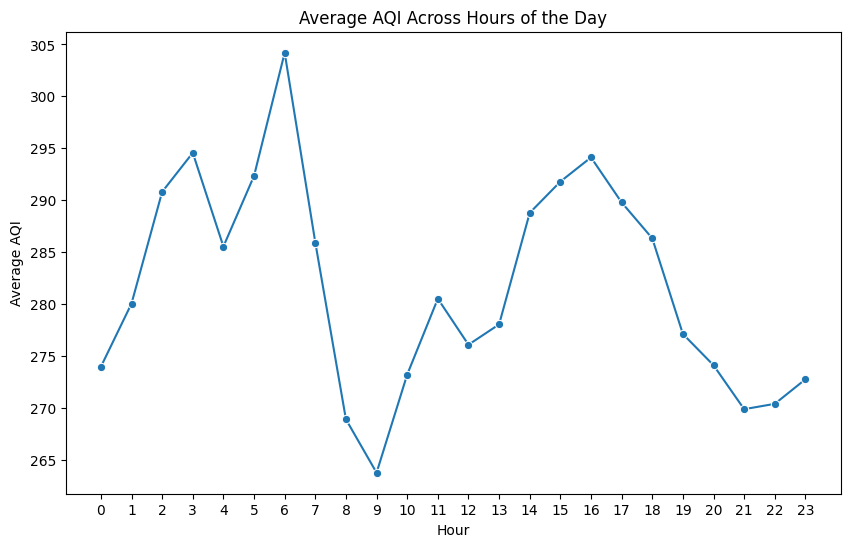

In [70]:
# Group by hour and calculate average AQI
hourly_avg_aqi = df.groupby('hour')['AQI'].mean().reset_index()

# Plot the average AQI
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='AQI', data=hourly_avg_aqi, marker='o')
plt.title('Average AQI Across Hours of the Day')
plt.xlabel('Hour')
plt.ylabel('Average AQI')
plt.xticks(range(0, 24))
plt.show()

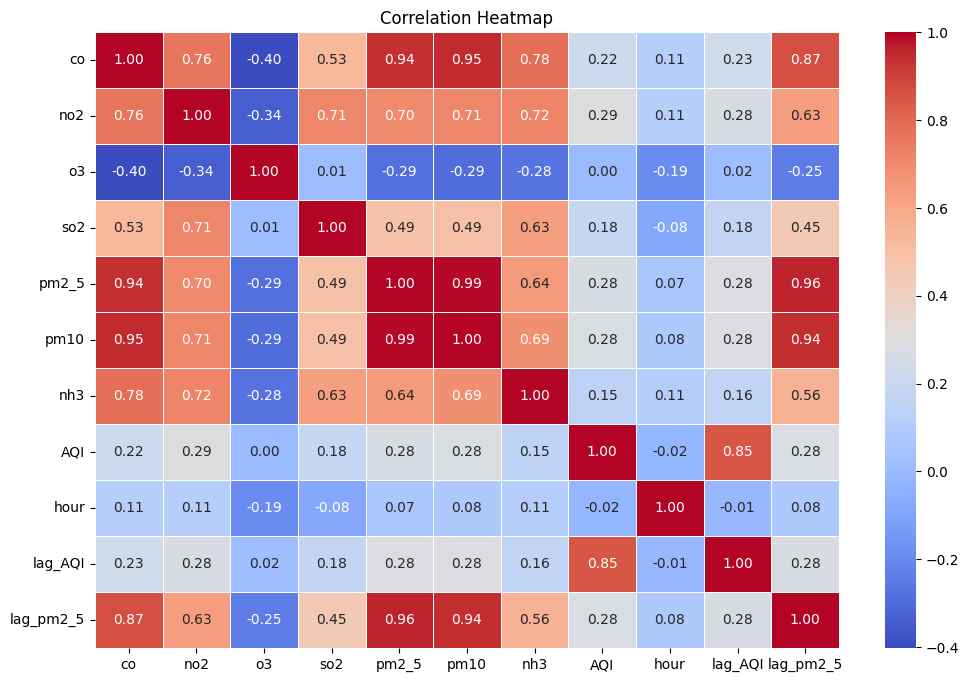

In [71]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [72]:
X = df.drop(columns=['AQI'])
y = df['AQI']

In [73]:
X.head()

,co,no2,o3,so2,pm2_5,pm10,nh3,season,hour,lag_AQI,lag_pm2_5,is_weekend
1,3.63159,89.11,0.33,54.36,420.96,486.21,41.04,Autumn,2,446.170241,364.61,False
2,4.53949,100.08,1.11,68.67,463.68,541.95,49.14,Autumn,3,468.574458,420.96,False
3,4.53949,111.04,6.44,78.20,454.81,534.00,48.13,Autumn,4,485.559518,463.68,False
4,4.37927,117.90,17.17,87.74,448.14,529.19,46.61,Autumn,5,482.032892,454.81,False
5,3.89862,117.90,40.05,101.09,437.25,511.79,42.05,Autumn,6,479.380964,448.14,False


In [74]:
y.head()

1    468.574458
2    485.559518
3    482.032892
4    479.380964
5    475.051205
Name: AQI, dtype: float64

In [75]:
X.describe()

,co,no2,o3,so2,pm2_5,pm10,nh3,hour,lag_AQI,lag_pm2_5
count,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000,18775.000000
mean,2.929245,66.221066,60.348730,66.695128,238.123572,300.087020,25.109628,11.497577,281.795798,238.136401
std,2.854599,48.528774,80.466351,49.440083,226.537777,267.171699,26.402799,6.922326,122.104934,226.538120
min,0.260350,4.280000,0.000000,5.250000,11.830000,15.070000,0.000000,0.000000,23.683333,11.830000
25%,1.068120,33.930000,0.340000,34.810000,84.440000,118.785000,9.630000,5.000000,177.939254,84.440000
50%,1.842500,54.150000,27.180000,52.930000,157.420000,209.690000,17.480000,11.000000,304.651429,157.470000
75%,3.685000,83.630000,92.980000,82.020000,312.915000,387.880000,30.400000,17.000000,381.834651,313.000000
max,21.148680,460.620000,801.090000,579.830000,1708.090000,1969.930000,287.770000,23.000000,500.000000,1708.090000


In [76]:
skewness = X[numerical_columns[:-1]].skew()
print(skewness)

co       2.005078
no2      2.034052
o3       1.996588
so2      2.669601
pm2_5    1.949492
pm10     1.868020
nh3      3.568220
dtype: float64


In [77]:
skewed_cols = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
X[skewed_cols] = X[skewed_cols].apply(lambda x: np.log1p(x))

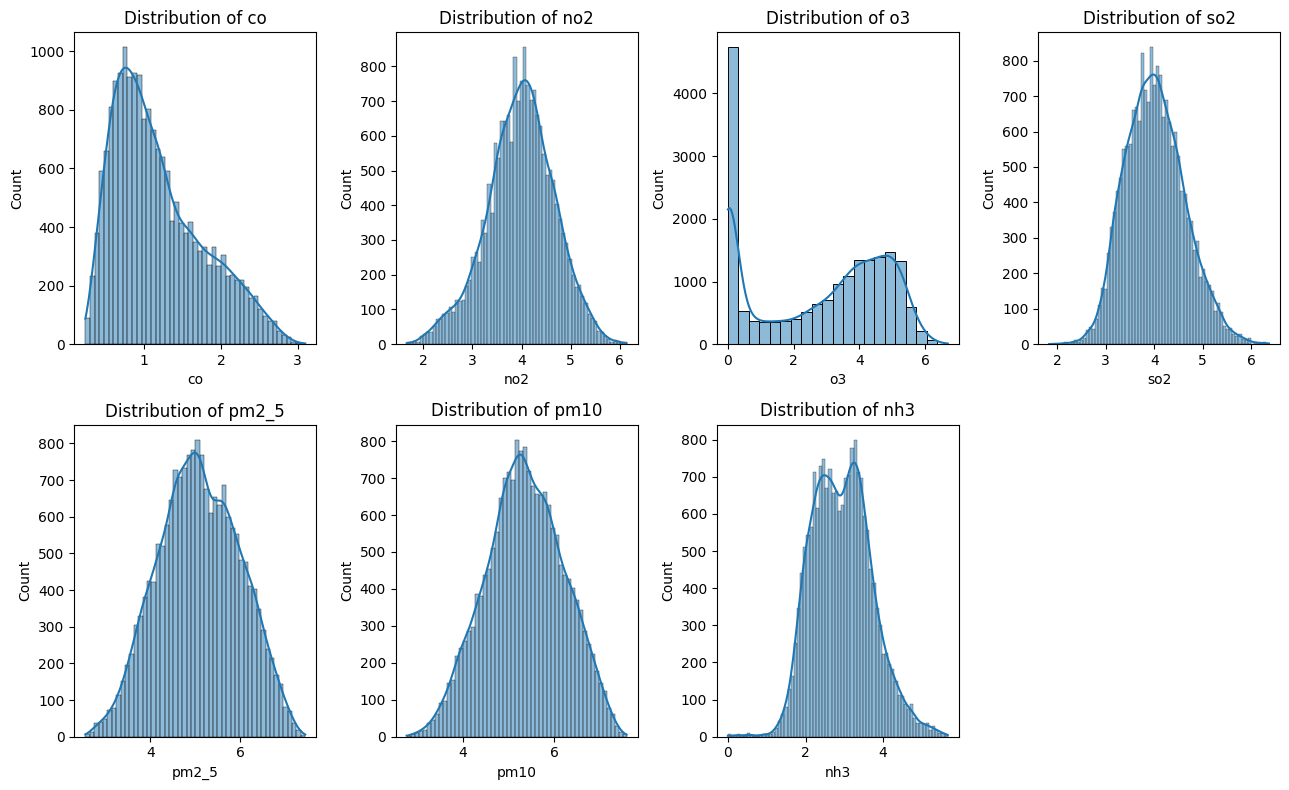

In [78]:
plt.figure(figsize=(13, 8))
for i, col in enumerate(skewed_cols, start=1):
    plt.subplot(2, 4, i)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [79]:
scaler = StandardScaler()
numerical_cols = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [80]:
X.describe()

,co,no2,o3,so2,pm2_5,pm10,nh3,hour,lag_AQI,lag_pm2_5
count,1.877500e+04,1.877500e+04,1.877500e+04,1.877500e+04,1.877500e+04,1.877500e+04,1.877500e+04,18775.000000,18775.000000,18775.000000
mean,-8.477314e-17,-2.724851e-16,-7.266269e-17,1.627342e-16,-1.816567e-16,7.871792e-16,1.816567e-17,11.497577,281.795798,238.136401
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,6.922326,122.104934,226.538120
min,-1.624673e+00,-3.361172e+00,-1.380757e+00,-3.578213e+00,-2.806826e+00,-3.042511e+00,-3.808897e+00,0.000000,23.683333,11.830000
25%,-7.737356e-01,-6.198846e-01,-1.235184e+00,-7.198150e-01,-7.065189e-01,-6.776426e-01,-7.477179e-01,5.000000,177.939254,84.440000
50%,-2.272738e-01,4.273966e-02,2.798639e-01,-4.934744e-02,-2.256086e-02,-1.284111e-02,-3.152152e-02,11.000000,304.651429,157.470000
75%,6.312777e-01,6.640453e-01,8.789654e-01,6.570374e-01,7.349922e-01,7.086980e-01,6.550302e-01,17.000000,381.834651,313.000000
max,3.300344e+00,3.125365e+00,1.945457e+00,3.842484e+00,2.612162e+00,2.619423e+00,3.528606e+00,23.000000,500.000000,1708.090000


In [81]:
X.head()

,co,no2,o3,so2,pm2_5,pm10,nh3,season,hour,lag_AQI,lag_pm2_5,is_weekend
1,0.611577,0.755076,-1.238910,-0.006495,1.062649,0.974087,1.032955,Autumn,2,446.170241,364.61,False
2,0.919138,0.921753,-1.009356,0.369974,1.169478,1.101613,1.261147,Autumn,3,468.574458,420.96,False
3,0.919138,1.071110,-0.382543,0.579905,1.148128,1.084248,1.234793,Autumn,4,485.559518,463.68,False
4,0.868710,1.157330,0.061585,0.766139,1.131799,1.073615,1.194092,Autumn,5,482.032892,454.81,False
5,0.707888,1.157330,0.466975,0.995617,1.104609,1.034330,1.063701,Autumn,6,479.380964,448.14,False


In [82]:
X = pd.get_dummies(X, columns=['season'], dtype='int64')
X.head()

,co,no2,o3,so2,pm2_5,pm10,nh3,hour,lag_AQI,lag_pm2_5,is_weekend,season_Autumn,season_Monsoon,season_Summer,season_Winter
1,0.611577,0.755076,-1.238910,-0.006495,1.062649,0.974087,1.032955,2,446.170241,364.61,False,1,0,0,0
2,0.919138,0.921753,-1.009356,0.369974,1.169478,1.101613,1.261147,3,468.574458,420.96,False,1,0,0,0
3,0.919138,1.071110,-0.382543,0.579905,1.148128,1.084248,1.234793,4,485.559518,463.68,False,1,0,0,0
4,0.868710,1.157330,0.061585,0.766139,1.131799,1.073615,1.194092,5,482.032892,454.81,False,1,0,0,0
5,0.707888,1.157330,0.466975,0.995617,1.104609,1.034330,1.063701,6,479.380964,448.14,False,1,0,0,0


In [83]:
X['is_weekend'] = X['is_weekend'].astype('int64')
X.head()

,co,no2,o3,so2,pm2_5,pm10,nh3,hour,lag_AQI,lag_pm2_5,is_weekend,season_Autumn,season_Monsoon,season_Summer,season_Winter
1,0.611577,0.755076,-1.238910,-0.006495,1.062649,0.974087,1.032955,2,446.170241,364.61,0,1,0,0,0
2,0.919138,0.921753,-1.009356,0.369974,1.169478,1.101613,1.261147,3,468.574458,420.96,0,1,0,0,0
3,0.919138,1.071110,-0.382543,0.579905,1.148128,1.084248,1.234793,4,485.559518,463.68,0,1,0,0,0
4,0.868710,1.157330,0.061585,0.766139,1.131799,1.073615,1.194092,5,482.032892,454.81,0,1,0,0,0
5,0.707888,1.157330,0.466975,0.995617,1.104609,1.034330,1.063701,6,479.380964,448.14,0,1,0,0,0


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (15020, 15), y_train shape: (15020,)
X_test shape: (3755, 15), y_test shape: (3755,)


In [85]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'Model': model.__class__.__name__,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }


In [86]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    KNeighborsRegressor(),
    SVR(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

results = []
for model in models:
    result = train_and_evaluate(model, X_train, X_test, y_train, y_test)
    results.append(result)

In [87]:
results_df = pd.DataFrame(results)
results_df

,Model,MAE,MSE,RMSE,R2
0,LinearRegression,35.389931,3823.566150,61.834991,0.751141
1,Lasso,35.160192,3969.997226,63.007914,0.741610
2,Ridge,35.387376,3823.726766,61.836290,0.751130
3,KNeighborsRegressor,31.506318,3245.045340,56.965299,0.788794
4,SVR,36.356777,4410.103578,66.408611,0.712965
5,RandomForestRegressor,1.362978,58.567492,7.652940,0.996188
6,AdaBoostRegressor,32.885762,1626.377903,40.328376,0.894146
7,GradientBoostingRegressor,7.922488,220.311253,14.842886,0.985661
8,XGBRegressor,5.142689,237.291153,15.404258,0.984556


Training R² score: 0.9994752194125343
Test R² score: 0.996362352383042


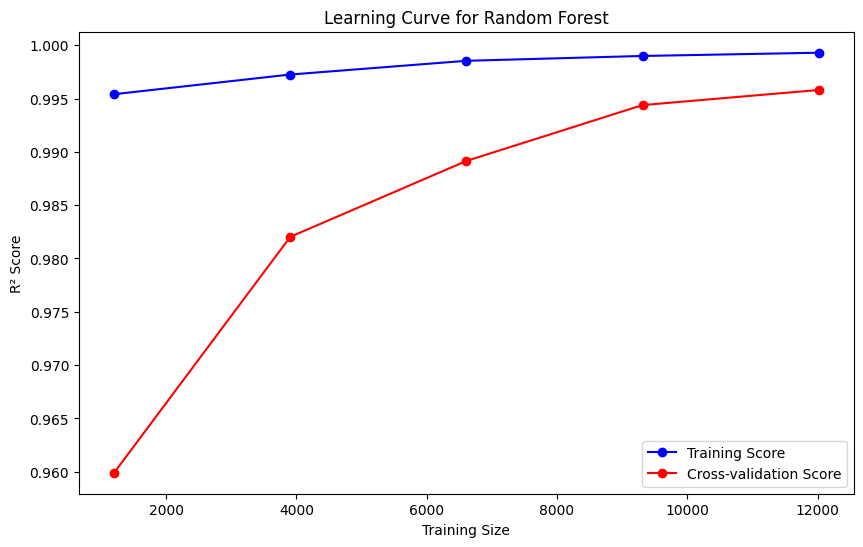

In [88]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
print(f'Training R² score: {train_r2}')
print(f'Test R² score: {test_r2}')


train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation Score', color='red', marker='o')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.show()

In [89]:
folder_path = os.path.join('E:\Air-Quality-Index-Prediction', 'saved_models')
os.makedirs(folder_path, exist_ok=True)
model_path = os.path.join(folder_path, 'rf_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(rf, file)
print(f"Model saved to {model_path}")

Model saved to E:\Air-Quality-Index-Prediction\saved_models\rf_model.pkl


In [90]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Average R² score: {cv_scores.mean()}")

Cross-validation R² scores: [0.99779567 0.99155516 0.99364893 0.99238735 0.99615417]
Average R² score: 0.9943082549767273
